In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import sys
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt # for plotting model loss
import json

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

In [42]:
# parameters
real_malware = ['WinWebSec'] # OnLineGames, Renos, VBInject, WinWebSec, Zbot
fake_malware = 'wws' # olgames, renos, vbinject, wws, zbot
savedir_malware = 'wws'
use_harshit = 0 # 1 to use Harshit's fake samples, other to use ours
unique_opcodes = 1 # 0 = visualize_explore/opcodes, 1 = fake_tests/opdicts
latent_dim = 2
opcode_len = 600
number_files = 10 # number of generated malware files

In [43]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding an opcode sequence."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [44]:
input_shape = (opcode_len,1)

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv1D(128, kernel_size=3, activation='relu', padding="same")(encoder_inputs)
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 600, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 600, 128)     512         ['input_5[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 600, 64)      24640       ['conv1d_4[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 38400)        0           ['conv1d_5[0][0]']               
                                                                                            

In [45]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(opcode_len * 32, activation="relu")(latent_inputs)
x = layers.Reshape((opcode_len, 32))(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(16, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 19200)             57600     
                                                                 
 reshape_2 (Reshape)         (None, 600, 32)           0         
                                                                 
 conv1d_transpose_6 (Conv1DT  (None, 600, 32)          3104      
 ranspose)                                                       
                                                                 
 conv1d_transpose_7 (Conv1DT  (None, 600, 16)          1552      
 ranspose)                                                       
                                                                 
 conv1d_transpose_8 (Conv1DT  (None, 600, 1)           49  

In [46]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            print(data)
            print(z)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=1
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [47]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# Python code to count the number of occurrences
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

# opcodes are indexed by overall frequency
def get_opcode_freq(opcode_frequency):
    rank = 0
    prev_count = -1
    for item in sorted(opcode_frequency,reverse=True):
        # increment rank if current opcode has different frequency than previous opcode
        if prev_count != item[0]:
            rank+=1
        # assign frequency rank
        opcode_frequency[item[1]] = rank
        # save previous frequency
        prev_count = item[0]
    return opcode_frequency

# opcodes are indexed by unique opcode position (opcodes_into_list)
def get_opcode_pos(data_into_list,opcodes_into_list):
    opcode_position = []
    nx = 0
    for x in data_into_list:
        ny = 0
        for y in opcodes_into_list:
            if x == y:
                opcode_position.append(ny)
                break
            ny+=1
        nx+=1
        # index for unknown opcodes
        if len(opcodes_into_list) == ny:
            opcode_position.append(ny)
    return opcode_position

# get opcode list from opdict
def get_opcode_dict(malware_fam,file_path):
    my_opcodes = file_path + 'opdict' + malware_fam + '.json'
    with open(my_opcodes) as json_file:
        data = json.load(json_file)
    return list(data.keys())

# initialize variables
dataset = []
dataset_names = []
dataset_ind = []

# iterate through families
for real in real_malware:

    # opening list of unique opcodes
    if unique_opcodes == 0:
        my_fp = './code/visualize_explore/opcodes/'
        my_opcodes = open(my_fp + 'opcodes' + real + '.txt','r')
        opcodes = my_opcodes.read()
        opcodes_into_list = opcodes.replace('\n', ' ').split(" ")
        opcodes_into_list.remove('')
        # close opcodes file
        my_opcodes.close()
    elif unique_opcodes == 1:
        my_fp = main_dir + '/code-20230116T073801Z-001/code/fake_tests/opdicts/'
        opcodes_into_list = get_opcode_dict(real,my_fp)

    # real malware parameters
    my_filepath = "../malware_data/" + real +'/'
    dir_list = os.listdir(my_filepath)

    # process real malware
    for fm in dir_list:
        # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
        print('Processing real malware' + my_filepath + fm)

        # opening the file in read mode
        my_file = open(my_filepath + fm, "r")

        # reading the file
        data = my_file.read()

        # replacing end of line('/n') with ' ' and
        # splitting the text it further when '.' is seen.
        data_into_list = data.replace('\n', ' ').split(" ")

        # remove '' from opcodes
        data_into_list.remove('')

        opcode_frequency = []
        if data_into_list:
                
            # create (opcode frequency, rank) tuple
            idx = 0
            for x in opcodes_into_list:
                count = countX(data_into_list, x)
                #print('{} has occurred {} times'.format(x,count))
                opcode_frequency.append((count,idx))
                idx+=1
            # print(sorted(opcode_frequency,reverse=True))

            # opcodes are indexed by overall frequency
            opcode_frequency = get_opcode_freq(opcode_frequency)

            # opcodes are indexed by opcodes_into_list position
            opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

            # add real malware to dataset
            dataset.append(opcode_position)
            dataset_names.append(fm)
            dataset_ind.append(0) # 0 is indicator for real malware
        else:
            # skip processing if malware file is empty
            print('------------> is empty ... skipping')

        # close file
        my_file.close()

# convert dataset to numpy arrays
X = np.array(dataset,dtype=object)
y = np.array(dataset_ind,dtype='int64')

# print
nSamples = len(X)
print('There are', nSamples, 'malware files')

Processing real malware../malware_data/WinWebSec/0009d99691e8eed99c7dd1500e07cda336d54260.asm.txt
Processing real malware../malware_data/WinWebSec/00113d9802cca3deba19cf9daa17f1c2269de2b8.asm.txt
Processing real malware../malware_data/WinWebSec/0036d720d8ff6c8f4860b5c69deba7c400e4d356.asm.txt
Processing real malware../malware_data/WinWebSec/0037c7716f1dc8e5c4e1f9a9f3e9d5aedb7a6979.asm.txt
Processing real malware../malware_data/WinWebSec/003824de7a82d2db9fc877c44ea93f76dd0e5ca9.asm.txt
Processing real malware../malware_data/WinWebSec/00427746e03afb4d3b28791a82315e52acf66a0b.asm.txt
Processing real malware../malware_data/WinWebSec/004bb59ba37917bfea49e6904f0551df7b3c719f.asm.txt
Processing real malware../malware_data/WinWebSec/005150c72b9cd08a62bc0d730e3593b4f160534a.asm.txt
Processing real malware../malware_data/WinWebSec/005231177f706856a0617a2c871d627ddedf54a7.asm.txt
Processing real malware../malware_data/WinWebSec/005e219370aaf892509b509b76cb082b36b16fcf.asm.txt
There are 10 malware

In [48]:
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# truncate and pad input sequences
max_sequence_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_sequence_length)

# reshape and normalize
norm_factor = 1/(len(opcodes_into_list)+1)
sample_size = X_train.shape[0]
time_steps = X_train.shape[1]
X_train_reshaped = X_train.reshape(sample_size, time_steps, 1)*norm_factor

# reshape and normalize
norm_factor = 1/(len(opcodes_into_list)+1)
sample_size = X_test.shape[0]
time_steps = X_test.shape[1]
X_test_reshaped = X_test.reshape(sample_size, time_steps, 1)*norm_factor

Epoch 1/200
Tensor("IteratorGetNext:0", shape=(None, 600, 1), dtype=float32)
Tensor("encoder/sampling_2/add:0", shape=(None, 2), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 600, 1), dtype=float32)
Tensor("encoder/sampling_2/add:0", shape=(None, 2), dtype=float32)
1/1 [==============================] - 1s 877ms/step - loss: 415.1199 - reconstruction_loss: 415.1177 - kl_loss: 0.0023
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 412.9797 - reconstruction_loss: 412.8714 - kl_loss: 0.1083
Epoch 3/200
1/1 [==============================] - 0s 14ms/step - loss: 411.2723 - reconstruction_loss: 410.7667 - kl_loss: 0.5056
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 407.2510 - reconstruction_loss: 406.7292 - kl_loss: 0.5217
Epoch 5/200
1/1 [==============================] - 0s 13ms/step - loss: 406.3752 - reconstruction_loss: 405.4137 - kl_loss: 0.9615
Epoch 6/200
1/1 [==============================] - 0s 13ms/step - loss: 403.4182

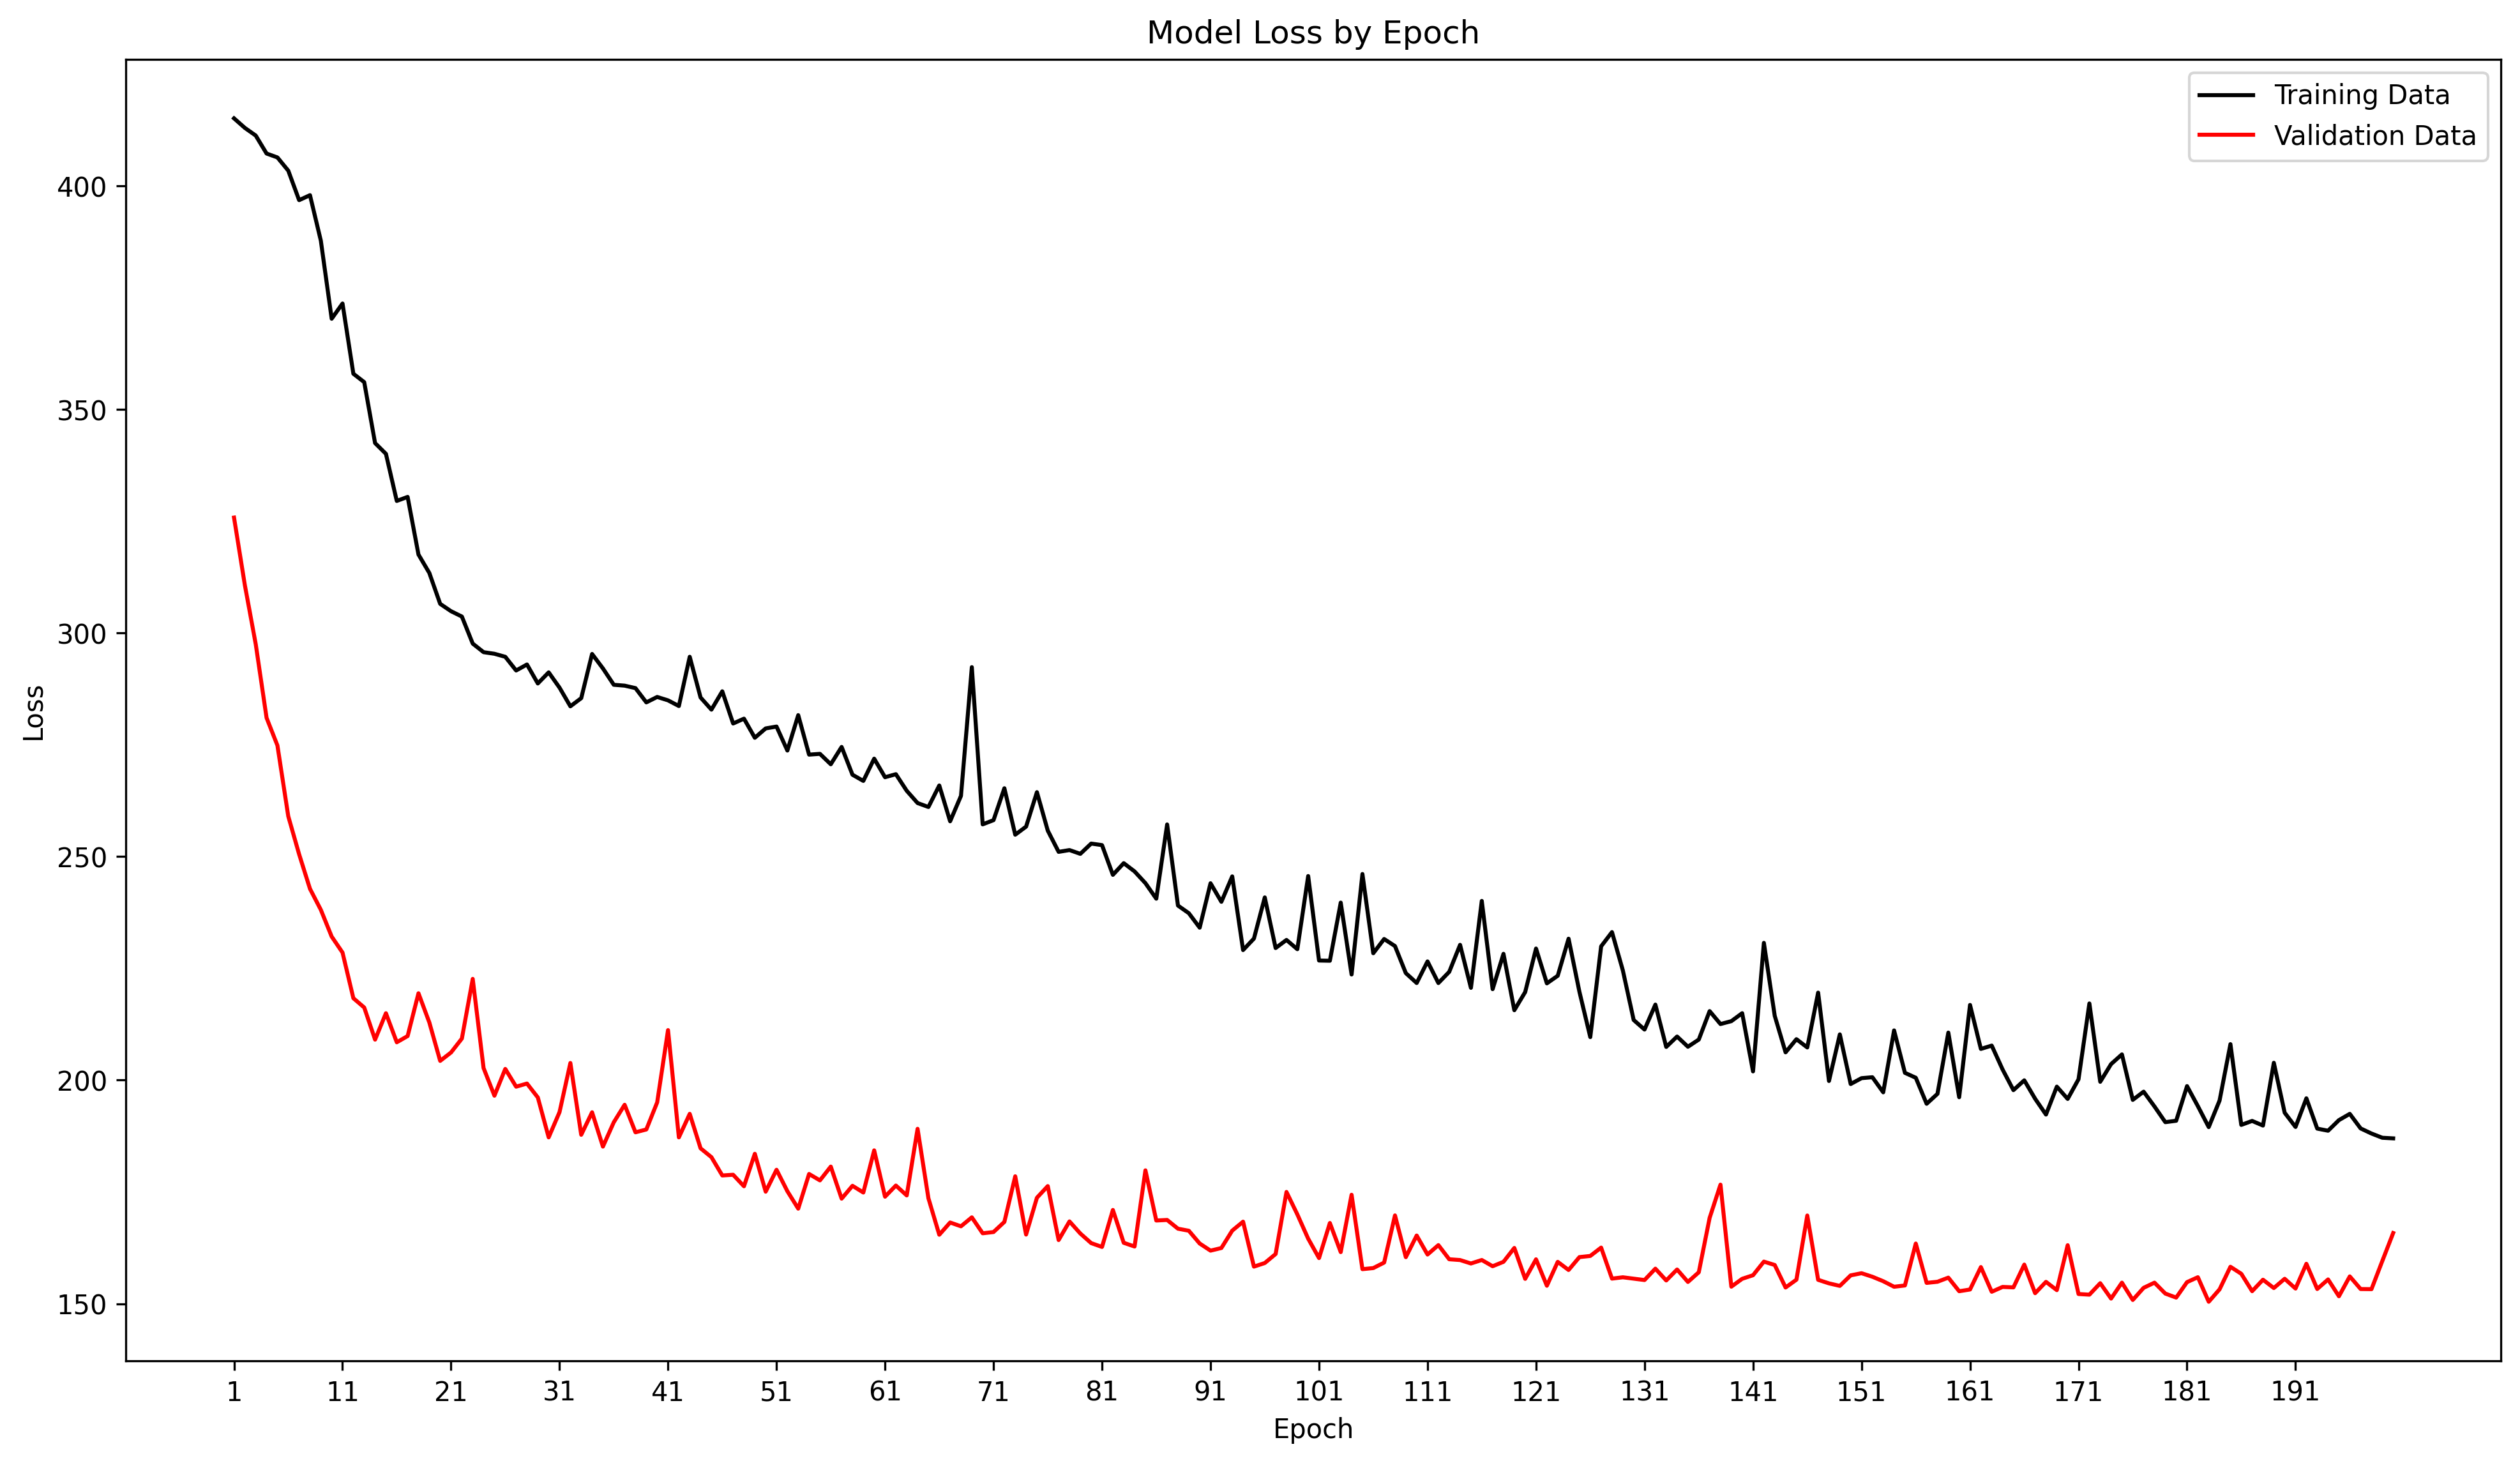

In [49]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history_train = vae.fit(X_train_reshaped, epochs=200, batch_size=16)
history_test = vae.fit(X_test_reshaped, epochs=200, batch_size=16)

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history_train.history['loss'], label='Training Data', color='black')
ax.plot(history_test.history['loss'], label='Validation Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history_train.history['loss']), step=10), labels=np.arange(1, len(history_train.history['loss'])+1, step=10))
plt.legend()
plt.show()

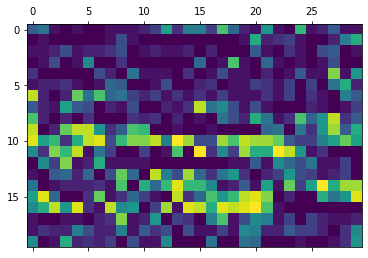

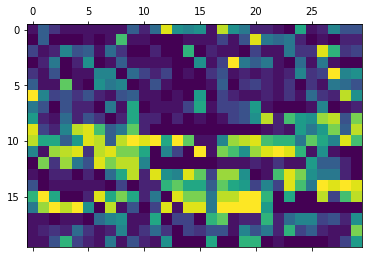

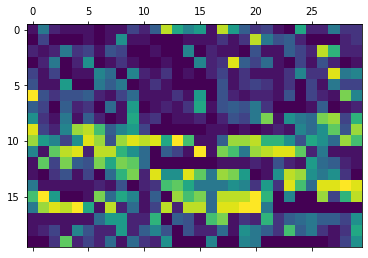

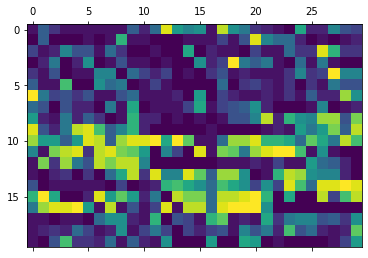

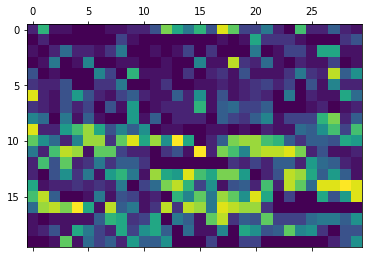

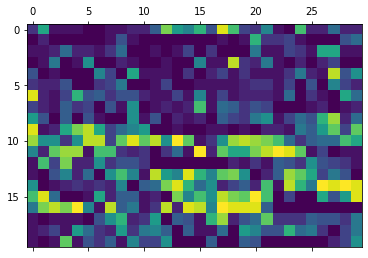

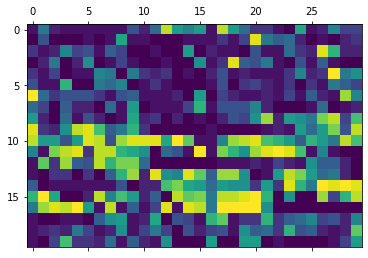

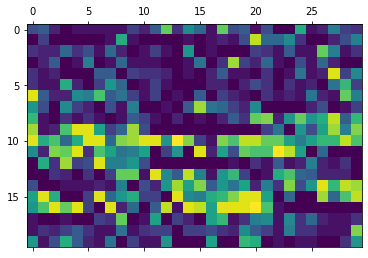

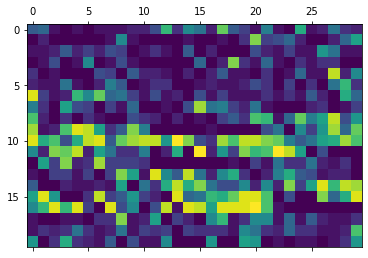

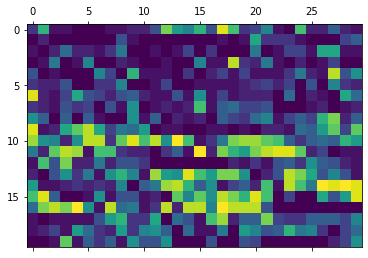

In [50]:
for nF in range(number_files):
    randomlist = []
    for i in range(0,latent_dim):
        #n = random.randint(1,20)
        #n = (random.random() - 0.5)*2
        n = random.random()
        randomlist.append(n)
    z_sample_opcode=[randomlist]

    opcode_decoded = vae.decoder.predict(z_sample_opcode)
    tmp = np.rint(opcode_decoded.reshape(20,30)*len(opcodes_into_list)).astype(int)

    # Reshape and display the image
    plt.matshow(tmp)
    plt.show()

    # map output back to opcodes and write
    my_fp = './code/fake_tests/vae_cnn_samples/'
    my_opcodes = open(my_fp + savedir_malware + '/' + 'generated_' + real + '_' + str(nF+1) + '.txt','a+')

    for row in tmp:
        for col in row:
            # random opcode if index greater than len(opcodes_into_list)
            if col >= len(opcodes_into_list) - 1:
                col = random.randint(0,len(opcodes_into_list) - 1)
            my_opcodes.write(opcodes_into_list[col])
            my_opcodes.write('\n')
    # close opcodes file
    my_opcodes.close()